In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from matplotlib.colors import ListedColormap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

### Image Classification Dataset Info
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). 

Inasive ductal carcinoma (IDC) is - with ~ 80 % of cases - one of the most common types of breast cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of breast cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefore deep learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available.

This notebook has been adapted from Allunia's Breast Cancer Notebook on Kaggle.

In [2]:
run_training = True
retrain = False
find_learning_rate = True

In [3]:
files = listdir("histopathology_images/")
#print(len(files))

In [4]:
base_path = "histopathology_images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
folder.remove(".DS_Store")
#len(folder)

In [5]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)


In [6]:
total_images

277524

In [7]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0       9036  histopathology_images/IDC_regular_ps50_idx5/90...      0
1       9036  histopathology_images/IDC_regular_ps50_idx5/90...      0
2       9036  histopathology_images/IDC_regular_ps50_idx5/90...      0
3       9036  histopathology_images/IDC_regular_ps50_idx5/90...      0
4       9036  histopathology_images/IDC_regular_ps50_idx5/90...      0

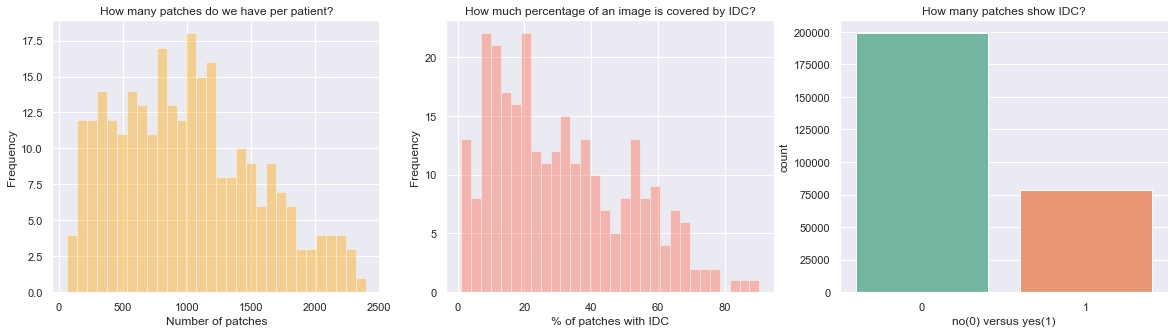

In [8]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

Insights
<br>The number of image patches per patient varies a lot. This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients.
<br>Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer.

In [9]:
data.target = data.target.astype(np.int)

In [10]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

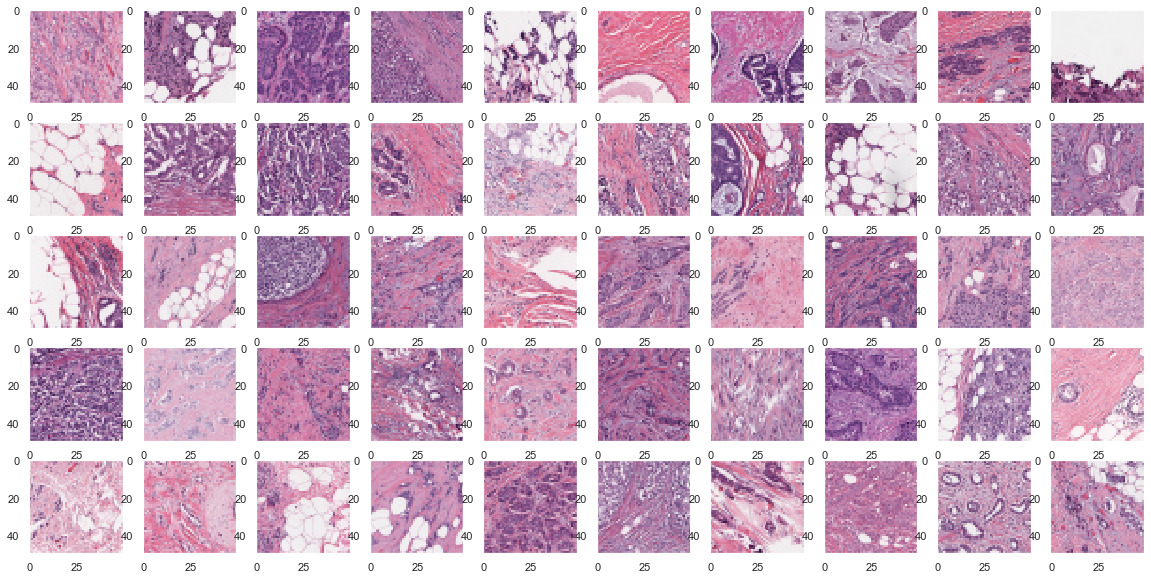

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

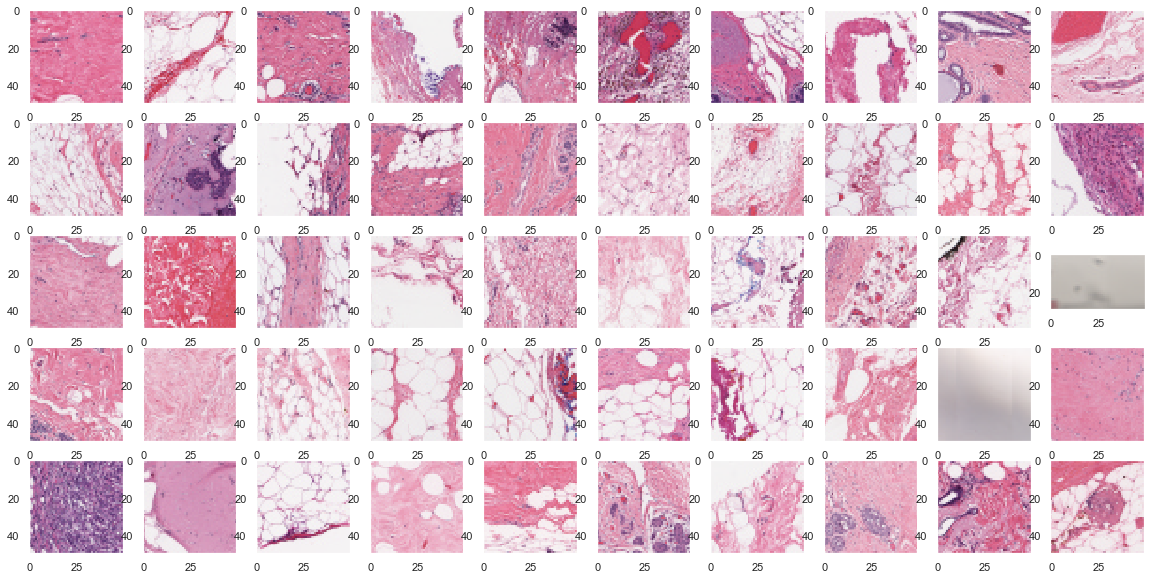

In [12]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Insights
* Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels.
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* We assume that the holes in the tissue belong to the mammary ducts where the milk can flow through.

### Visualising the breast tissue 
We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [13]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [14]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1051  2401       0  histopathology_images/IDC_regular_ps50_idx5/90...
1  2951   951       0  histopathology_images/IDC_regular_ps50_idx5/90...
2  3001  1451       0  histopathology_images/IDC_regular_ps50_idx5/90...
3  3051   801       0  histopathology_images/IDC_regular_ps50_idx5/90...
4   951  1901       0  histopathology_images/IDC_regular_ps50_idx5/90...

### Binary target visualisation per tissue slice 
<br>Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

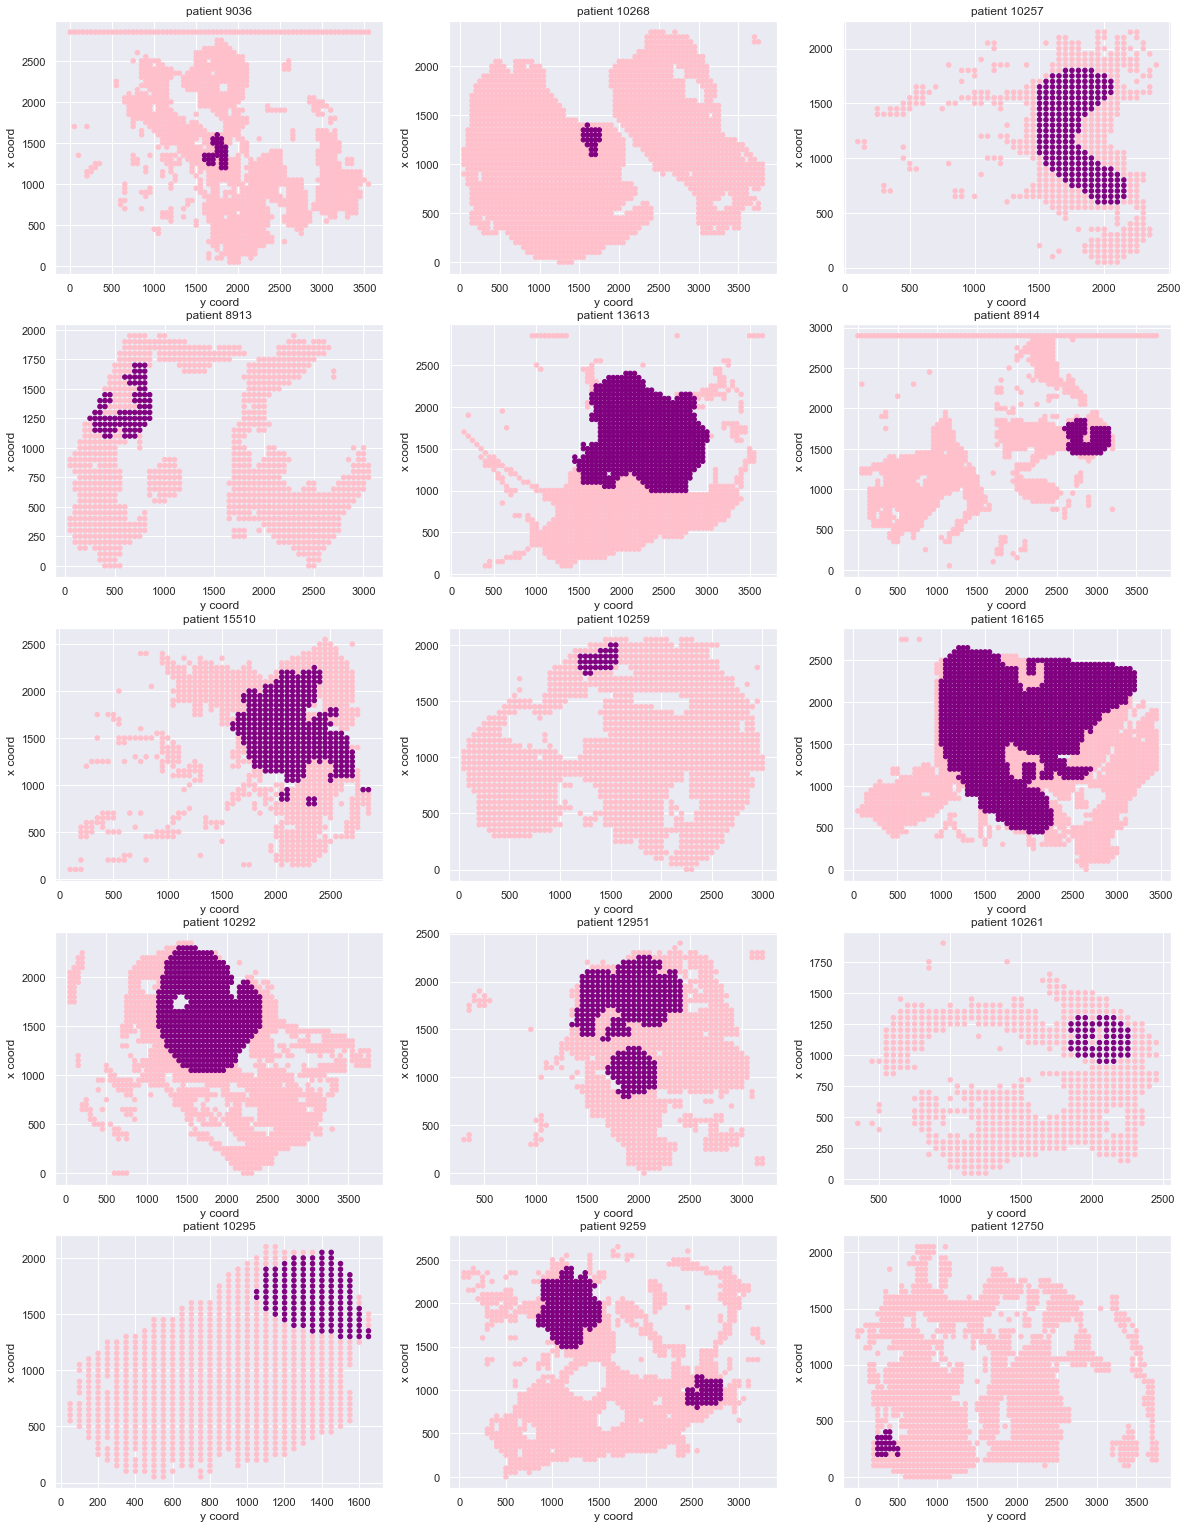

In [15]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))
patient_ids = data.patient_id.unique()
colors = ['pink', 'purple']
for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap=ListedColormap(colors), s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

<span style="font-size:1.5em"> Insights </span>
* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.
* Reading the paper (link!) that seems to be related to this data this could also be part of the preprocessing.

<span style="font-size:1.5em"> Visualising the breast tissue images </span>
<br><br>Ok, now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets).

In [16]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

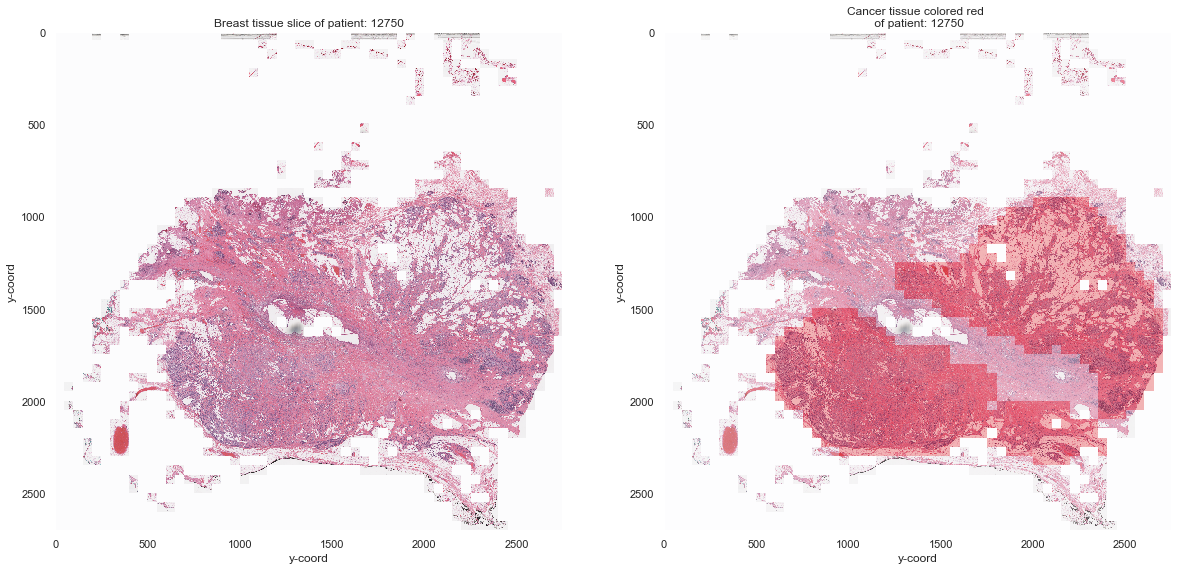

In [17]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

Insights
* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color.
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color.
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer!
* Sometimes it's not possible to load an image patch as the path is ill defined. But in our case, we were able to load them all:

In [18]:
broken_patches

[]

## Setting up the machine learning workflow

In [19]:
BATCH_SIZE = 32
NUM_CLASSES = 2

OUTPUT_PATH = "bcm"
MODEL_PATH = "bcm"

In [20]:
torch.manual_seed(0)
np.random.seed(0)

<span style="font-size:1.5em">Validation strategy</span> 

<p>Let's start very simple by selecting 30 % of the patients as test data and the remaining 70 % for training and developing.</p>

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
patient_id    277524 non-null object
path          277524 non-null object
target        277524 non-null int64
dtypes: int64(1), object(2)
memory usage: 18.5+ MB


In [22]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [23]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


In [24]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


In [25]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

Text(0.5, 1.0, 'Test data')

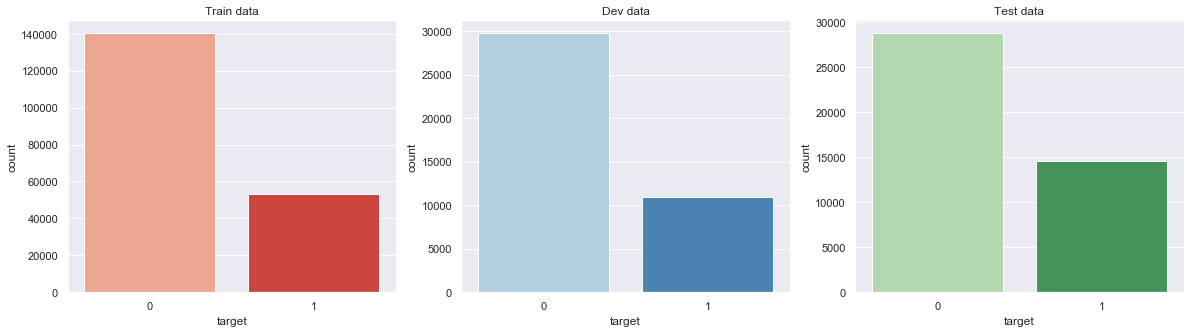

In [26]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(test_df.target, ax=ax[2], palette="Greens");
ax[2].set_title("Test data")

<span style="font-size:1.5em">Creating pytorch image datasets</span>

It's often a good idea to start as simple as possible and to grow more complex while iterating through the solution. This way we prevent to build up models that are likely overfitted to the available data and we can find out useful ideas in a strategic manner instead of trying out every idea at random.
<br><br>
The simplest transformations we can do for each image are:
* resizing the images to the desired input shape
* performing horizontal and vertical flips

<p>
In our case the patches are of shape 50x50x3 and we could set this as our input shape. As CNNs are translational but not rotational invariant, it's a good idea to add flips during training. This way we increase the variety of our data in a meaningful way as each patch could be rotated as well on the tissue slice. As we are not looking at the whole tissue we are not loosing spatial connections between patches and it's not important that some neighboring patches are rotated in different directions.</p>

In [27]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

Furthermore we need to create a dataset that loads an image patch of a patient, converts it to RGB, performs the augmentation if it's desired and returns the image, the target, the patient id and the image coordinates.

In [28]:
class BreastCancerDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [29]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [30]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

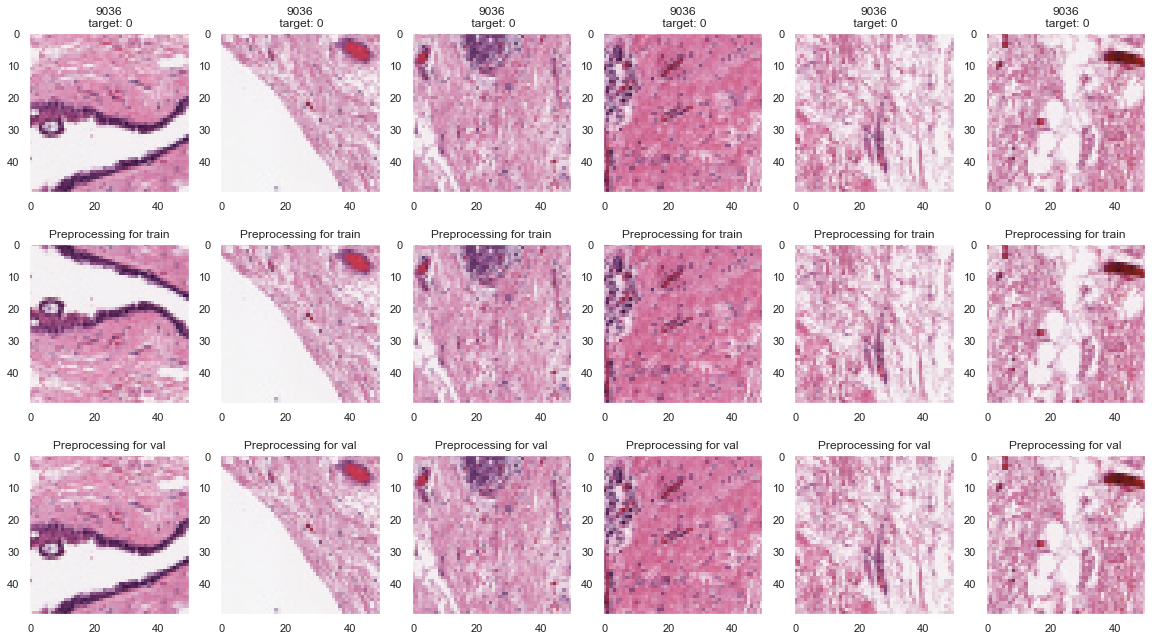

In [31]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    filepath = train_df.path.values[m]
    image = Image.open(filepath)
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(str(train_df.patient_id.values[m]) + "\n target: " + str(train_df.target.values[m]))
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

### Creating pytorch dataloaders

As the gradients for each learning step are computed over batches we benefit from shuffling the training data after each epoch. This way each batch is composed differently and we don't start to learn for specific sequences of images. For validation and training we drop the last batch that often consists less images than the batch size.

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [33]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [34]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

6043 1272 1357


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [36]:
model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


### Loss Function

The task to predict the presence of inasive ductal carcinoma given a tissue patch is a binary classification. A common loss for this problem is the binary cross entropy function. Using it we could only use one single output neuron to make predictions. As I like to compute the f1-score during training and prediction and I need to compute false and true positives/negatives in a simple manner I will use the cross entropy loss with K=2 output neurons or 2 classes that can be hot (1) or cold (0) with

In [37]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6896, 1.8184])


In [38]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

### Selecting an evaluation metric

The percentage of correct predictions (accuracy score) is not a good evaluation metric for imbalanced target distributions. Imagine our model would predict "no cancer" for all patches. Even then we still obtain a accuracy score higher than 0.5 and we have no further insights.

### F1 Score
The harmonic mean of precision and recall

In [39]:
def f1_score(preds, targets):
    
    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)
    
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

In [40]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")
    
    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [41]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)
                        
                        #loss += l2_reg
            
                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step() 
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)
                            
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                      
     
                counter += 1
                
                
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [42]:
start_lr = 1e-6
end_lr = 0.001

In [43]:
if run_training:
    NUM_EPOCHS = 20
    optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
    scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
    results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
    model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]
    
    if device == "cpu":
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth"
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["dev"]
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_breastcancer.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_breastcancer.csv", index=False)

Epoch 0/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




dev Loss: 0.4481 Acc: 0.8081


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4687 Acc: 0.7963


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4723 Acc: 0.7891

Epoch 2/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4605 Acc: 0.8009


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4711 Acc: 0.7880

Epoch 3/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4536 Acc: 0.8037


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4626 Acc: 0.7957

Epoch 4/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4504 Acc: 0.8043


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4691 Acc: 0.7916

Epoch 5/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4467 Acc: 0.8073


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4684 Acc: 0.7924

Epoch 6/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4458 Acc: 0.8074


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4735 Acc: 0.7876

Epoch 7/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4422 Acc: 0.8096


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4745 Acc: 0.7895

Epoch 8/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4413 Acc: 0.8090


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4613 Acc: 0.7931

Epoch 9/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4407 Acc: 0.8100


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4637 Acc: 0.7930

Epoch 10/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4384 Acc: 0.8101


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4697 Acc: 0.7898

Epoch 11/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4390 Acc: 0.8104


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4364 Acc: 0.8115



dev Loss: 0.4121 Acc: 0.8201



test Loss: 0.4637 Acc: 0.7919

Epoch 13/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4584 Acc: 0.7979

Epoch 14/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




dev Loss: 0.4093 Acc: 0.8212


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




test Loss: 0.4660 Acc: 0.7909

Epoch 16/19
----------


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




dev Loss: 0.4086 Acc: 0.8233


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




dev Loss: 0.4094 Acc: 0.8204


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




train Loss: 0.4317 Acc: 0.8148



dev Loss: 0.4303 Acc: 0.8093



test Loss: 0.4810 Acc: 0.7848

Epoch 19/19
----------



train Loss: 0.4320 Acc: 0.8125



dev Loss: 0.4168 Acc: 0.8177



test Loss: 0.4667 Acc: 0.7938

Training complete in 913m 52s
Best val Acc: 0.823324


### Exploring Losses

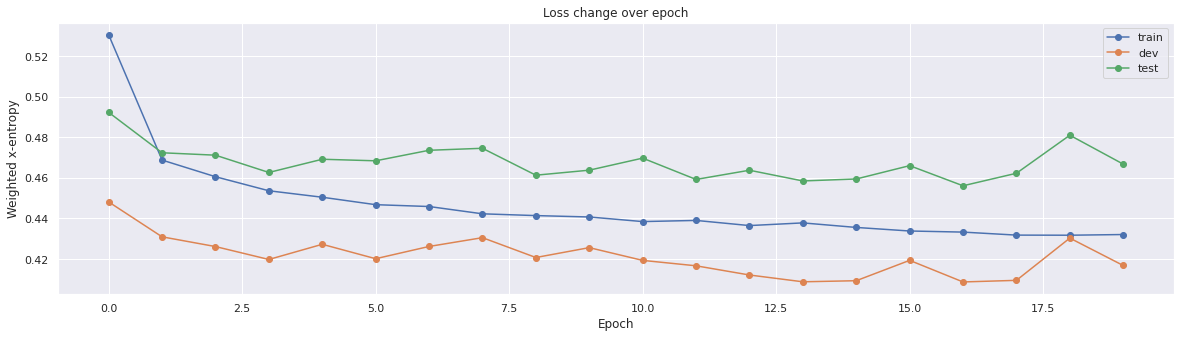

In [49]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

### The probability landscape of invasive ductal carcinoma 

In [43]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]
            
    predictions_df = predictions_df.dropna()
    return predictions_df

In [44]:
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")
    
    dev_predictions.to_csv("dev_predictions.csv", index=False)
    test_predictions.to_csv("test_predictions.csv", index=False)
    
else:
    
    dev_predictions = pd.read_csv("dev_predictions.csv")
    test_predictions = pd.read_csv("test_predictions.csv")
    
    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

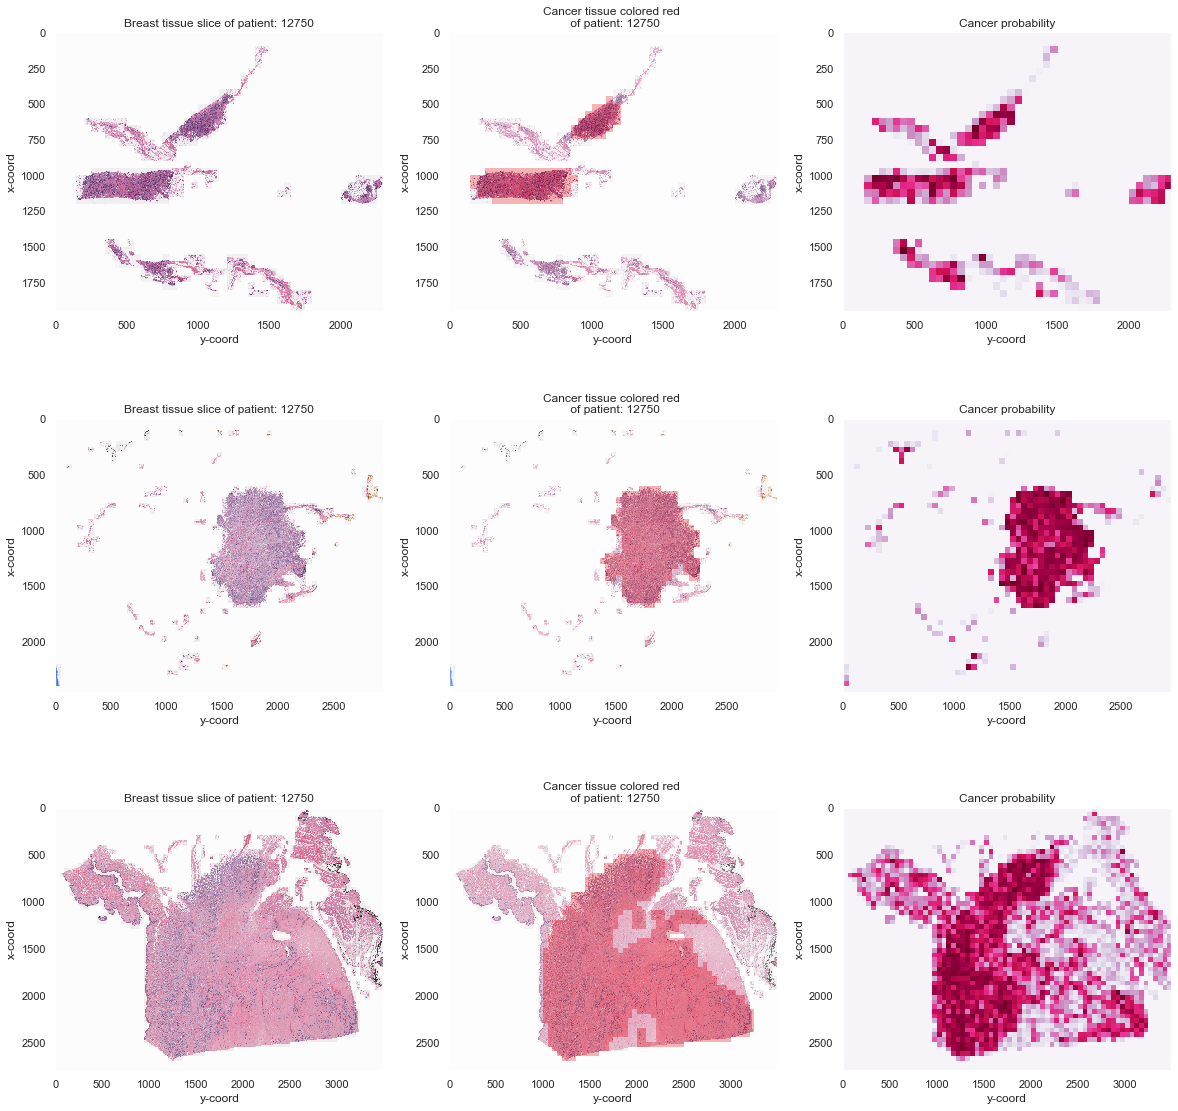

In [45]:
fig, ax = plt.subplots(3,3,figsize=(20,20))

for n in range(3):

    idx = dev_predictions.patient_id.unique()[3*n]
    grid, mask, broken_patches, mask_proba = visualise_breast_tissue(idx, pred_df=dev_predictions)


    ax[n, 0].imshow(grid, alpha=0.9)
    ax[n, 1].imshow(mask, alpha=0.8)
    ax[n, 1].imshow(grid, alpha=0.7)
    ax[n, 2].imshow(mask_proba[:,:,0], cmap="PuRd")

    for m in range(3):
        ax[n, m].set_xlabel("y-coord")
        ax[n, m].set_ylabel("x-coord")
        ax[n, m].grid(False)
        
    ax[n, 0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[n, 1].set_title("Cancer tissue colored red \n of patient: " + patient_id);
    ax[n, 2].set_title("Cancer probability");

### Evaluation Scores

In [46]:
dev_predictions.head()

true  predicted     proba       x       y patient_id
0     0          0  0.224798  1751.0  1801.0      10255
1     0          0  0.182417   251.0  1151.0      10255
2     0          0  0.500413   451.0   601.0      10255
3     0          0  0.668539   201.0   601.0      10255
4     0          1  0.748216   701.0  1651.0      10255

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_predictions["true"], test_predictions["predicted"])

array([[22003,  4991],
       [ 2727,  8383]])

In [48]:
from sklearn.metrics import classification_report 
print(classification_report(test_predictions["true"], test_predictions["predicted"]))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     26994
           1       0.63      0.75      0.68     11110

    accuracy                           0.80     38104
   macro avg       0.76      0.78      0.77     38104
weighted avg       0.81      0.80      0.80     38104

